<a href="https://colab.research.google.com/github/ibonetc/AI_Deep-Learning/blob/main/IA_DL_StableDiffusionNetworkKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes de difusión con Keras (Stable diffusion network)

In [ ]:
!pip install --upgrade keras-cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 KB 14.1 MB/s eta 0:00:00


In [ ]:
import time
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt


You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [ ]:
keras.mixed_precision.set_global_policy("mixed_float16")

## Crear modelo

In [ ]:
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


## Generar imágenes
Utilizando el modelo con la función *text_to_image* podemos, a patir de un texto descriptivo, generar imágenes. La función tiene dos parámetros:



*   **promp**: descripción del texto para la generación de imágenes. La descripción del texto afecta la calidad de la imagen, así que se debe ser lo más específico posible. Se puede además mencionar el nombre de un artista, los estilos artísticos o los medios artísticos, como la pintura acrílica y la pintura al óleo, ayuda a crear las imágenes que está buscando. En el siguiente ejemplo se menciona el nombre del artista *picasso*, los efectos de la pintura:  *highly detailed*(altamente detallados), el estilo artístico: *impressionism* (impresionista) y el medio: *oil painting* (pintura al óleo).
*   **batch_size**: Número de imágenes generadas



In [ ]:
images = model.text_to_image(prompt="A painting of a modern city by picasso, highly detailed, impressionism, oil painting",batch_size=2)

492466864/492466864 [==============================] - 5s 0us/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


198180272/198180272 [==============================] - 2s 0us/step


In [ ]:
def plot_images(images):
  plt.figure(figsize=(20, 20))
  for i in range(len(images)):
    ax = plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis("off")

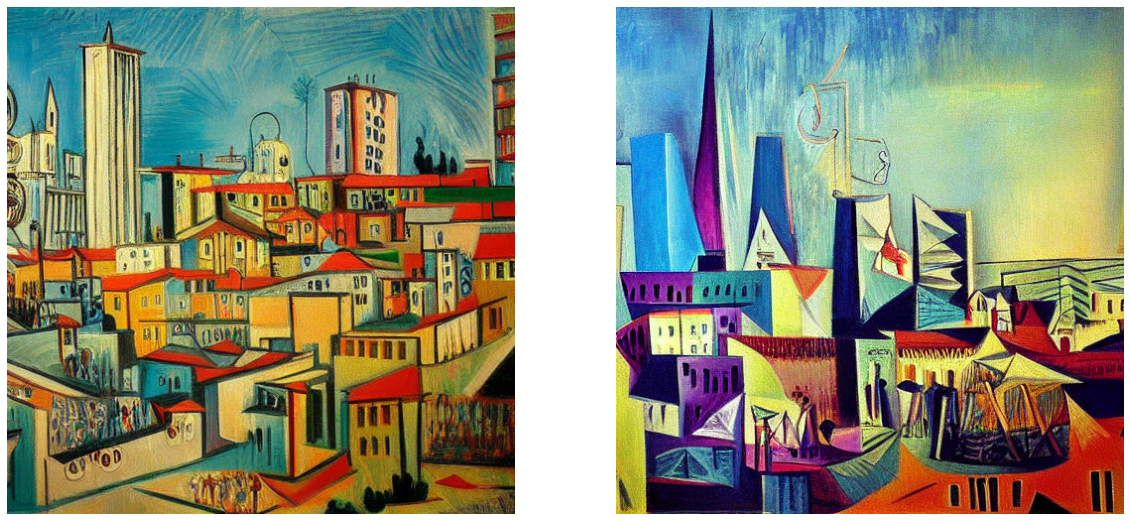

In [ ]:
plot_images(images)

TensorFlow viene con el compilador XLA: Accelerated Linear Algebra incorporado. keras_cv.models.StableDiffusion admite un argumento *jit_compile* listo para usar. Establecer este argumento en True habilita la compilación XLA, lo que resulta en una aceleración significativa.

In [ ]:
model = keras_cv.models.StableDiffusion(jit_compile=True)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


50/50 [==============================] - 72s 710ms/step


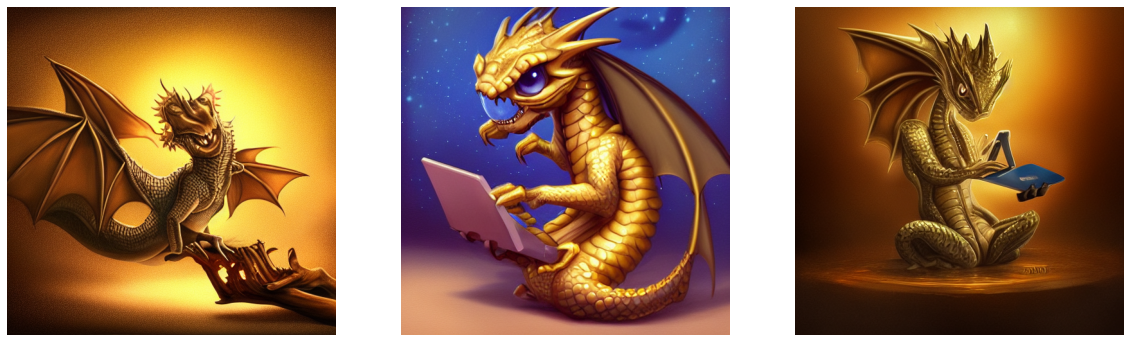

In [ ]:
images_dragon = model.text_to_image("A baby dragon holding a computer, golden color, high quality, highly detailed, elegant, concept art, character concepts, digital painting, realistic", batch_size=3)
plot_images(images_dragon)

50/50 [==============================] - 24s 478ms/step


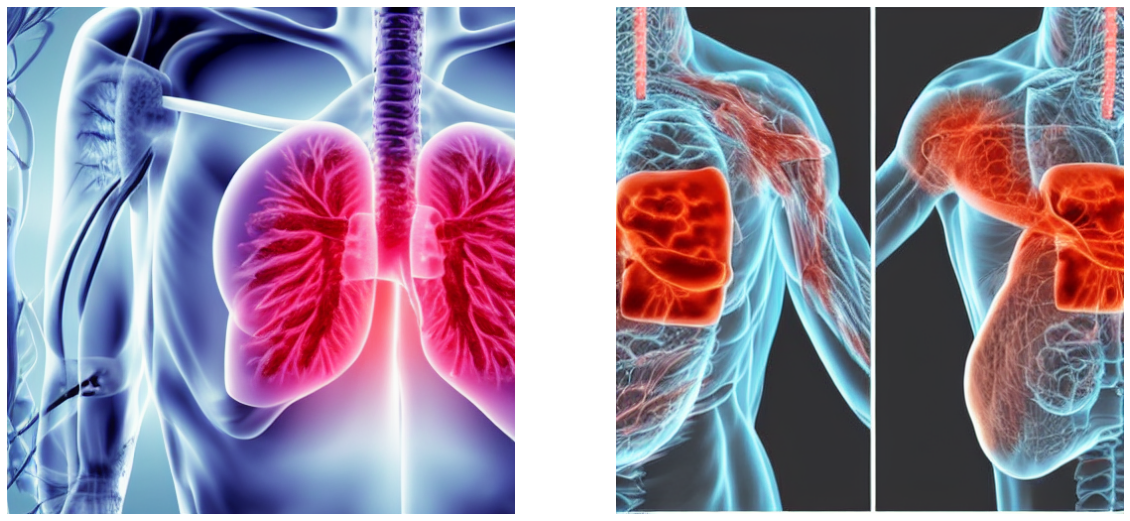

In [ ]:
images_lung = model.text_to_image("lung RX with EPOC, high quality, highly detailed,medical image", batch_size=2)
plot_images(images_lung)

## Guardando las imágenes generadas

In [ ]:
from PIL import Image

In [ ]:
path="/content/drive/MyDrive/Datos_AD/"

In [ ]:
for i,image in enumerate(images_dragon):
  Image.fromarray(image).save(path+"dragon"+str(i)+".png")

## Probando otro modelo entrenado

Este [modelo](https://github.com/sayakpaul/stable-diffusion-keras-ft) fue entrenado con una base de [pokemon](https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions) en una transferencia de conocimiento (fine-tuning) con 70 épocas.

In [ ]:
weights_path = keras.utils.get_file(
    origin="https://huggingface.co/sayakpaul/kerascv_sd_pokemon_finetuned/resolve/main/ckpt_epochs_72_res_512_mp_True.h5"
)

img_height = img_width = 512
pokemon_model = keras_cv.models.StableDiffusion(
    img_width=img_width, img_height=img_height
)
pokemon_model.diffusion_model.load_weights(weights_path)

3439089408/3439089408 [==============================] - 88s 0us/step
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


3439090152/3439090152 [==============================] - 25s 0us/step


198180272/198180272 [==============================] - 1s 0us/step


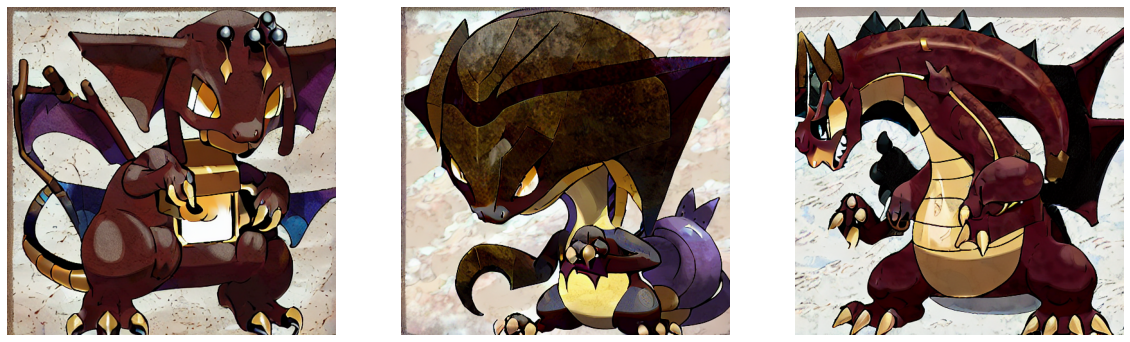

In [ ]:
prompt="A baby dragon holding a computer, golden color, high quality, highly detailed, elegant, concept art, character concepts, digital painting, realistic"
pokemon_dragon = pokemon_model.text_to_image(prompt, batch_size=3, unconditional_guidance_scale=40)
plot_images(pokemon_dragon)

# Fine Tuning
Podemos intentar entrenar el modelo, partiendo de los pesos que tiene, con otros datos, o sea, un modelo como este que se probó, pero necesita mucho capacidad de cómputo.
Ejemplo tomado de:

https://github.com/sayakpaul/stable-diffusion-keras-ft

In [ ]:
from textwrap import wrap
import os

import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras

### Descargar datos de la base de pokemon

In [ ]:
data_path = tf.keras.utils.get_file(
    origin="https://huggingface.co/datasets/sayakpaul/pokemon-blip-original-version/resolve/main/pokemon_dataset.tar.gz",
    untar=True,
)

data_frame = pd.read_csv(os.path.join(data_path, "data.csv"))

data_frame["image_path"] = data_frame["image_path"].apply(
    lambda x: os.path.join(data_path, x)
)
data_frame.head()

347504640/347504640 [==============================] - 6s 0us/step


image_path  \
0  /root/.keras/datasets/pokemon_dataset/image_0.png   
1  /root/.keras/datasets/pokemon_dataset/image_1.png   
2  /root/.keras/datasets/pokemon_dataset/image_2.png   
3  /root/.keras/datasets/pokemon_dataset/image_3.png   
4  /root/.keras/datasets/pokemon_dataset/image_4.png   

                                             caption  
0         a drawing of a green pokemon with red eyes  
1             a green and yellow toy with a red nose  
2  a red and white ball with an angry look on its...  
3           a cartoon ball with a smile on it's face  
4          a bunch of balls with faces drawn on them

In [ ]:
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

# Cargar tokenizador
tokenizer = SimpleTokenizer()

#  Tokenizar el texto
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)


# poner los textos en un arreglo
tokenized_texts = np.empty((len(data_frame), MAX_PROMPT_LENGTH))

all_captions = list(data_frame["caption"].values)
for i, caption in enumerate(all_captions):
    tokenized_texts[i] = process_text(caption)

### Preparar los datos


*  Codificar los texto de los tokens de los subtítulos
*   Carga y aumento de imágenes
*   Aleatorizar y poner los datos por batches

In [ ]:
RESOLUTION = 256
AUTO = tf.data.AUTOTUNE
POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

augmenter = keras_cv.layers.Augmenter(
    layers=[
        keras_cv.layers.CenterCrop(RESOLUTION, RESOLUTION),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)
text_encoder = TextEncoder(MAX_PROMPT_LENGTH)


def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, tokenized_text


def apply_augmentation(image_batch, token_batch):
    return augmenter(image_batch), token_batch


def run_text_encoder(image_batch, token_batch):
    return (
        image_batch,
        token_batch,
        text_encoder([token_batch, POS_IDS], training=False),
    )


def prepare_dict(image_batch, token_batch, encoded_text_batch):
    return {
        "images": image_batch,
        "tokens": token_batch,
        "encoded_text": encoded_text_batch,
    }


def prepare_dataset(image_paths, tokenized_texts, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tokenized_texts))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(process_image, num_parallel_calls=AUTO).batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.map(run_text_encoder, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_dict, num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)


In [ ]:
# Cargar los datos de entrenamiento
training_dataset = prepare_dataset(
    np.array(data_frame["image_path"]), tokenized_texts, batch_size=4
)

#Tomar un bach para verificar el tamaño del mismo
sample_batch = next(iter(training_dataset))

for k in sample_batch:
    print(k, sample_batch[k].shape)

images (4, 256, 256, 3)
tokens (4, 77)
encoded_text (4, 77, 768)


In [ ]:
sample_batch = next(iter(training_dataset))

Mostrar unas imágenes de ejemplo

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(3):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow((sample_batch["images"][i] + 1) / 2)

    text = tokenizer.decode(sample_batch["tokens"][i].numpy().squeeze())
    text = text.replace("<|startoftext|>", "")
    text = text.replace("<|endoftext|>", "")
    text = "\n".join(wrap(text, 12))
    plt.title(text, fontsize=15)

    plt.axis("off")

### Clase de entrenamiento

In [ ]:
class Trainer(tf.keras.Model):
    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        images = inputs["images"]
        encoded_text = inputs["encoded_text"]
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            latents = latents * 0.18215
            noise = tf.random.normal(tf.shape(latents))
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            target = noise
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            timestep_embedding = tf.squeeze(timestep_embedding, 1)
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, encoded_text], training=True
            )
            loss = self.compiled_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )


### Inicializar y compilar

In [ ]:

USE_MP = True
if USE_MP:
    keras.mixed_precision.set_global_policy("mixed_float16")

image_encoder = ImageEncoder(RESOLUTION, RESOLUTION)
diffusion_ft_trainer = Trainer(
    diffusion_model=DiffusionModel(RESOLUTION, RESOLUTION, MAX_PROMPT_LENGTH),
    vae=tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-2].output,
    ),
    noise_scheduler=NoiseScheduler(),
    use_mixed_precision=USE_MP,
)

lr = 1e-5
beta_1, beta_2 = 0.9, 0.999
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=lr,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
diffusion_ft_trainer.compile(optimizer=optimizer, loss="mse")

### Entrenar

In [ ]:
epochs = 5
ckpt_path = "finetuned_stable_diffusion.h5"
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
diffusion_ft_trainer.fit(training_dataset, epochs=epochs, callbacks=[ckpt_callback])